## Regression of home prices

#### Libraries

In [2]:
import pandas as pd
import numpy as np
import scipy as sp
import xgboost as xgb

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.cross_validation import train_test_split

from sklearn.decomposition import PCA

import statsmodels.api as sm

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
pd.options.display.max_columns = 79

#### Load data

In [4]:
DATADIR = './Data/'
TRAIN_FILE = 'train.csv'
TEST_FILE = 'test.csv'

In [5]:
train_raw = pd.read_csv(DATADIR+TRAIN_FILE)
test_raw = pd.read_csv(DATADIR+TEST_FILE)

In [6]:
IDS = test_raw['Id']
del test_raw['Id']
del train_raw['Id']

In [7]:
# Y = train_raw['SalePrice'].as_matrix()
Y = np.log(train_raw['SalePrice'].as_matrix())
del train_raw['SalePrice']

#### Model testing

In [8]:
train_raw.shape

(1460, 79)

In [9]:
train_raw.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


In [10]:
train_raw.SaleType.value_counts()

WD       1267
New       122
COD        43
ConLD       9
ConLw       5
ConLI       5
CWD         4
Oth         3
Con         2
Name: SaleType, dtype: int64

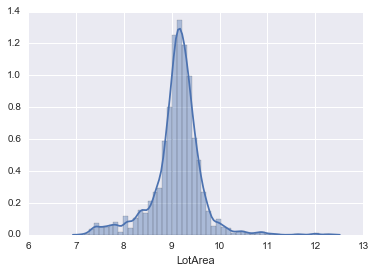

In [11]:
sns.distplot(np.log(train_raw.LotArea))

In [12]:
catcol = lambda x: sm.categorical(x.reshape(1,-1), drop=True)
intercept = np.ones(train_raw.shape[0])
model = sm.OLS(Y, 
               np.column_stack((
                    # continuous
                    np.log(train_raw.LotArea),
                    np.log(train_raw.GrLivArea),
                    train_raw['2ndFlrSF'],
                    train_raw.EnclosedPorch>0,
                    train_raw.LotFrontage.fillna(0),
                    train_raw.OverallQual,
                    train_raw.BsmtFinSF1,
                    np.log(train_raw.TotalBsmtSF+1e-12),
                    train_raw.BsmtFullBath,
                    train_raw.HalfBath,
                    train_raw.BedroomAbvGr,
                    train_raw.KitchenAbvGr,
                    train_raw.TotRmsAbvGrd,
                    train_raw.Fireplaces,
                    train_raw.GarageYrBlt.fillna(0),
                    train_raw.GarageCars,
                    train_raw.WoodDeckSF,
            
                    # categorical 
                    catcol(train_raw.YearBuilt),
                    catcol(train_raw.OverallQual),
                    catcol(train_raw.OverallCond),
                    catcol(train_raw.HouseStyle),
                    catcol(train_raw.Neighborhood),
                    catcol(train_raw.BldgType),
                    catcol(train_raw.Street),
                    catcol(train_raw.Functional),
                    catcol(train_raw.MSZoning),
                    catcol(train_raw.RoofMatl),
                    catcol(train_raw.Exterior1st),
                    catcol(train_raw.MasVnrType),
                    catcol(train_raw.ExterCond),
                    catcol(train_raw.Foundation),
                    catcol(train_raw.BsmtQual),
                    catcol(train_raw.BsmtCond),
                    catcol(train_raw.BsmtExposure),
                    catcol(train_raw.BsmtFinType1),
                    catcol(train_raw.Heating),
                    catcol(train_raw.HeatingQC),
                    catcol(train_raw.CentralAir),
                    catcol(train_raw.KitchenQual),
                    catcol(train_raw.GarageType),
                    catcol(train_raw.GarageFinish),
                    catcol(train_raw.Fence),
                    catcol(train_raw.SaleCondition),
            
                    # intercept
                    intercept
                ))
               )
res = model.fit()

/usr/local/lib/python2.7/site-packages/numpy/lib/arraysetops.py:200: FutureWarning: numpy not_equal will not check object identity in the future. The comparison did not return the same result as suggested by the identity (`is`)) and will change.
  flag = np.concatenate(([True], aux[1:] != aux[:-1]))
/usr/local/lib/python2.7/site-packages/statsmodels/tools/tools.py:221: FutureWarning: numpy equal will not check object identity in the future. The comparison did not return the same result as suggested by the identity (`is`)) and will change.
  tmp_dummy = (tmp_arr[:, None] == data).astype(float)


In [13]:
print res.aic

-2131.31865033


In [14]:
print res.rsquared_adj

0.927758473872


In [15]:
outliers = res.outlier_test()

In [16]:
outlier_index = outliers[:,2]<=0.05

In [17]:
train_raw.loc[outlier_index,:]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
30,70,C (all),50.0,8500,Pave,Pave,Reg,Lvl,AllPub,Inside,Gtl,IDOTRR,Feedr,Norm,1Fam,2Story,4,4,1920,1950,Gambrel,CompShg,BrkFace,BrkFace,None,0.0,TA,Fa,BrkTil,TA,TA,No,Unf,0,Unf,0,649,649,GasA,TA,N,SBrkr,649,668,0,1317,0,0,1,0,3,1,TA,6,Typ,0,NaN,Detchd,1920.0,Unf,1,250,TA,Fa,N,0,54,172,0,0,0,NaN,MnPrv,NaN,0,7,2008,WD,Normal
462,20,RL,60.0,8281,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Sawyer,Norm,Norm,1Fam,1Story,5,5,1965,1965,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,553,BLQ,311,0,864,GasA,Gd,Y,SBrkr,864,0,0,864,0,0,1,0,3,1,TA,5,Typ,1,Po,Detchd,1965.0,Unf,1,360,TA,TA,Y,0,0,236,0,0,0,NaN,GdWo,NaN,0,12,2009,WD,Normal
523,60,RL,130.0,40094,Pave,NaN,IR1,Bnk,AllPub,Inside,Gtl,Edwards,PosN,PosN,1Fam,2Story,10,5,2007,2008,Hip,CompShg,CemntBd,CmentBd,Stone,762.0,Ex,TA,PConc,Ex,TA,Gd,GLQ,2260,Unf,0,878,3138,GasA,Ex,Y,SBrkr,3138,1538,0,4676,1,0,3,1,3,1,Ex,11,Typ,1,Gd,BuiltIn,2007.0,Fin,3,884,TA,TA,Y,208,406,0,0,0,0,NaN,NaN,NaN,0,10,2007,New,Partial
588,20,RL,65.0,25095,Pave,NaN,IR1,Low,AllPub,Inside,Sev,ClearCr,Norm,Norm,1Fam,1Story,5,8,1968,2003,Flat,Tar&Grv,Wd Sdng,Wd Sdng,None,0.0,TA,TA,CBlock,TA,TA,Gd,GLQ,1324,Unf,0,113,1437,GasA,Ex,Y,SBrkr,1473,0,0,1473,2,0,1,0,1,1,Ex,5,Typ,2,Gd,Attchd,1968.0,Unf,1,452,TA,TA,Y,0,48,0,0,60,0,NaN,NaN,NaN,0,6,2009,WD,Partial
632,20,RL,85.0,11900,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,Norm,1Fam,1Story,7,5,1977,1977,Hip,CompShg,Plywood,Plywood,BrkFace,209.0,TA,Gd,CBlock,TA,TA,No,ALQ,822,Unf,0,564,1386,GasA,TA,Y,SBrkr,1411,0,0,1411,0,0,2,0,3,1,TA,6,Typ,1,TA,Attchd,1977.0,Fin,2,544,TA,TA,Y,192,0,0,0,0,0,NaN,NaN,NaN,0,4,2009,WD,Family
968,50,RM,50.0,5925,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Norm,Norm,1Fam,1.5Fin,3,6,1910,1950,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,BrkTil,TA,TA,No,Unf,0,Unf,0,600,600,Grav,Fa,N,SBrkr,600,368,0,968,0,0,1,0,2,1,TA,6,Typ,0,NaN,NaN,NaN,NaN,0,0,NaN,NaN,Y,0,0,0,0,0,0,NaN,GdWo,NaN,0,5,2009,WD,Abnorml
970,50,RL,60.0,10800,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1.5Fin,4,4,1949,1950,Gable,CompShg,AsbShng,AsbShng,None,0.0,TA,TA,CBlock,TA,TA,No,Unf,0,Unf,0,720,720,GasA,TA,N,FuseA,720,472,0,1192,0,0,1,1,4,1,TA,6,Typ,0,NaN,NaN,NaN,NaN,0,0,NaN,NaN,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,12,2006,WD,Abnorml
1324,20,RL,75.0,9986,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,1Fam,1Story,8,5,2006,2007,Gable,CompShg,VinylSd,VinylSd,BrkFace,428.0,Gd,TA,PConc,Ex,TA,Av,Unf,0,Unf,0,1795,1795,GasA,Ex,Y,SBrkr,1795,0,0,1795,0,0,2,0,2,1,Gd,7,Typ,1,Gd,Attchd,2007.0,RFn,3,895,TA,TA,Y,0,49,0,0,0,0,NaN,NaN,NaN,0,2,2007,New,Partial
1453,20,RL,90.0,17217,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1Story,5,5,2006,2006,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,Unf,0,Unf,0,1140,1140,GasA,Ex,Y,SBrkr,1140,0,0,1140,0,0,1,0,3,1,TA,6,Typ,0,NaN,NaN,NaN,NaN,0,0,NaN,NaN,Y,36,56,0,0,0,0,NaN,NaN,NaN,0,7,2006,WD,Abnorml


In [18]:
Y = Y[~outlier_index]
train_raw = train_raw.loc[~outlier_index,:]

In [19]:
def transforms(df):
    # log transforms
    df.LotArea = np.log(df.LotArea)
    df.GrLivArea = np.log(train_raw.GrLivArea)
    train_raw.TotalBsmtSF = np.log(train_raw.TotalBsmtSF+1e-12)
    
#     # fill missing values 
#     df.LotFrontage = df.LotFrontage.fillna(0)
#     df.GarageYrBlt = train_raw.GarageYrBlt.fillna(0)
    
    # binary encoding
    df.EnclosedPorch = df.EnclosedPorch>0
    
    # change numeric to string value
    df.YearBuilt = df.YearBuilt.astype(str)
    df.OverallQual = df.OverallQual.astype(str)
    df.OverallCond = df.OverallCond.astype(str)
    
    # Delete un-needed columns
    del df['PoolArea']
    del df['ScreenPorch']
    del df['3SsnPorch']
    del df['Utilities']
    del df['LotConfig']
    del df['LotShape']
    del df['LandContour']
    del df['LandSlope']
    del df['Condition1']
    del df['Condition2']
    del df['YearRemodAdd']
    del df['RoofStyle']
    del df['Exterior2nd']
    del df['MasVnrArea']
    del df['ExterQual']
    del df['BsmtFinType2']
    del df['BsmtFinSF2']
    del df['Electrical']
    del df['LowQualFinSF']
    del df['FullBath']
    del df['Alley']
    del df['FireplaceQu']
    del df['GarageArea']
    del df['GarageQual']
    del df['GarageCond']
    del df['PavedDrive']
    del df['OpenPorchSF']
    del df['PoolQC']
    del df['MiscFeature']
    del df['MiscVal']
    del df['MoSold']
    del df['YrSold']
    del df['SaleType']
    
    df = df.convert_objects(convert_numeric=True)
    return df

train_raw = transforms(train_raw)
test_raw = transforms(test_raw)

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:54: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.


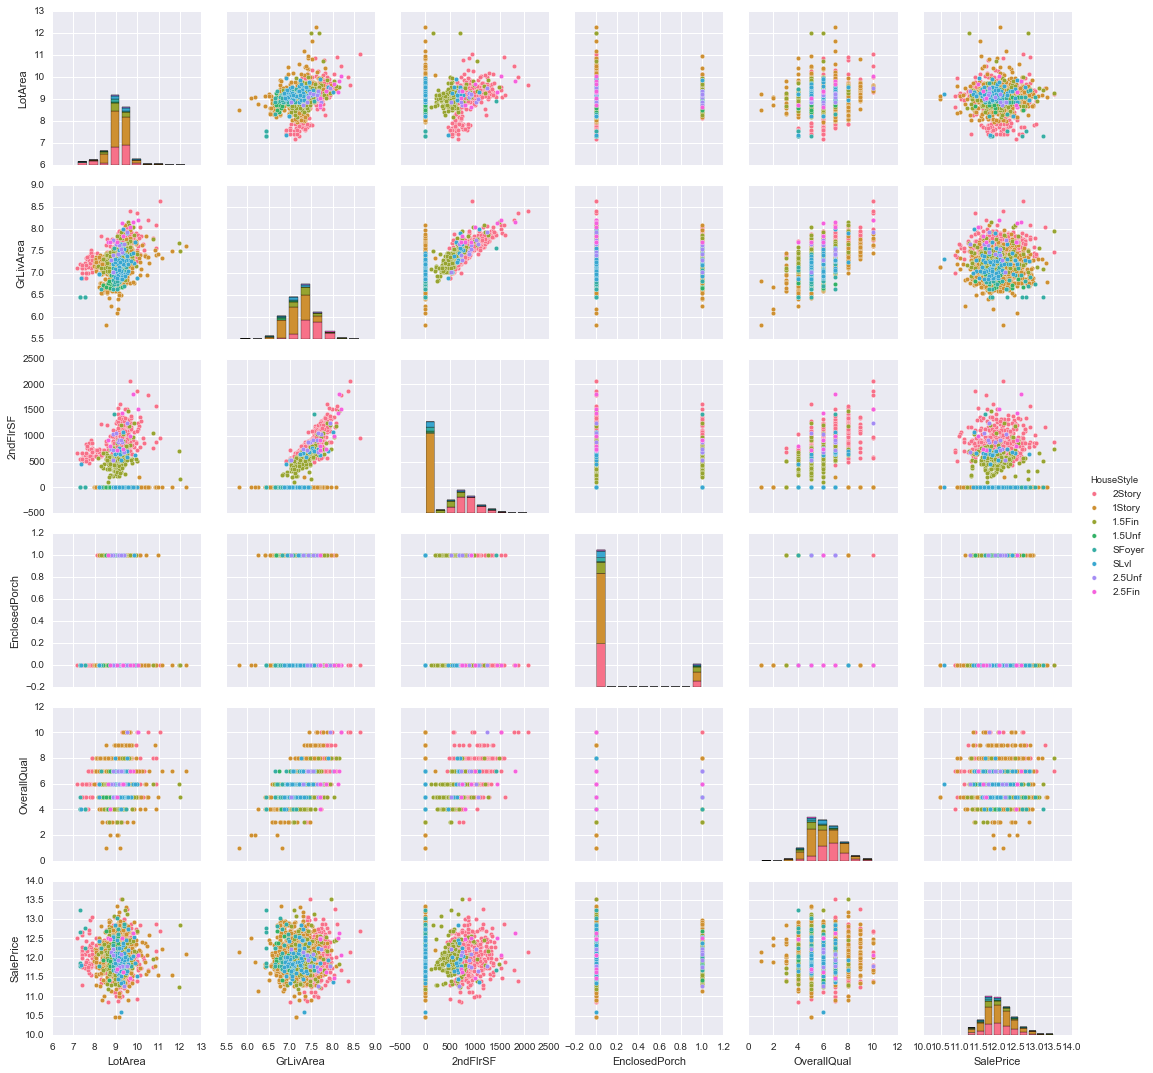

In [20]:
cols = [
    'LotArea'
    ,'GrLivArea'
    ,'2ndFlrSF'
    ,'EnclosedPorch'
    ,'OverallQual'
    ,'HouseStyle'
]
sns.pairplot(pd.concat((train_raw[cols],
                        pd.DataFrame(Y, columns=['SalePrice'])),
                       axis=1),
            hue='HouseStyle')

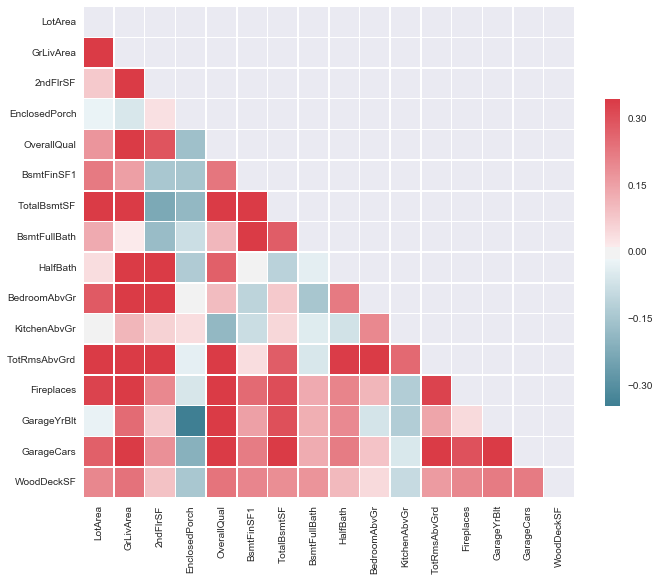

In [21]:
cols = [
    'LotArea'
    ,'GrLivArea'
    ,'2ndFlrSF'
    ,'EnclosedPorch'
    ,'OverallQual'
    ,'BsmtFinSF1'
    ,'TotalBsmtSF'
    ,'BsmtFullBath'
    ,'HalfBath'
    ,'BedroomAbvGr'
    ,'KitchenAbvGr'
    ,'TotRmsAbvGrd'
    ,'Fireplaces'
    ,'GarageYrBlt'
    ,'GarageCars'
    ,'WoodDeckSF'
]
# Compute the correlation matrix
corr = train_raw[cols].corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 11))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3,
            square=True, xticklabels=True, yticklabels=True,
            linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)

#### Create one-hot representation 

In [22]:
dtypes = train_raw.dtypes
categoricals = []
for i, f in enumerate(train_raw.columns):
    if train_raw.dtypes[f] == np.dtype('O'):
        le = LabelEncoder()
        concat = (train_raw[f],test_raw[f])
        le.fit(np.hstack(concat))
        train_raw[f] = le.transform(train_raw[f])
        test_raw[f] = le.transform(test_raw[f])
        categoricals.append(i)

/usr/local/lib/python2.7/site-packages/numpy/lib/arraysetops.py:259: FutureWarning: numpy equal will not check object identity in the future. The comparison did not return the same result as suggested by the identity (`is`)) and will change.
  return aux[:-1][aux[1:] == aux[:-1]]


In [23]:
train_raw = train_raw.fillna(0)
test_raw = test_raw.fillna(0)
ohe = OneHotEncoder(categorical_features=categoricals)
ohe.fit(np.vstack((train_raw,test_raw)))
X = ohe.transform(train_raw)
X_test = ohe.transform(test_raw)

#### Scale data

In [24]:
ss = StandardScaler()
X = ss.fit_transform(X.A)
X_test = ss.transform(X_test.A)

#### PCA

In [25]:
pca = PCA()
pca.fit(X)
f = 5
X_pca = pca.transform(X)
X_test_pca = pca.transform(X_test)
X = np.hstack((X,X_pca[:,:f]))
X_test = np.hstack((X_test,X_test_pca[:,:f]))

#### Train-test split

In [26]:
# X_train, X_val, y_train, y_val = train_test_split( X, Y, test_size=0.25)
X_train, X_val, y_train, y_val = X[:1000], X[1000:], Y[:1000], Y[1000:]

In [27]:
dtrain = xgb.DMatrix( X_train, label=y_train )
dval = xgb.DMatrix( X_val, label=y_val )
dtest = xgb.DMatrix( X_test )

#### Boosted trees model 

In [28]:
d = 3
e = 0.01
t = 2000
param = {'max_depth':d, 
         'eta':e, 
         'subsample':0.5, 
         'colsample_bytree':0.5,
         'colsample_bylevel':0.5,
         'silent':1, 
         'lambda':1.0,
         'objective':'reg:linear' }
param['eval_metric'] = 'rmse'
param['nthread'] = 2
evallist  = [(dval,'eval'), (dtrain,'train')]
xgb_model = xgb.train(param.items(), dtrain, t+1, evallist, verbose_eval=t//10)

[0]	eval-rmse:11.407731	train-rmse:11.424998
[200]	eval-rmse:1.545516	train-rmse:1.560624
[400]	eval-rmse:0.246635	train-rmse:0.247230
[600]	eval-rmse:0.130716	train-rmse:0.103401
[800]	eval-rmse:0.125768	train-rmse:0.087071
[1000]	eval-rmse:0.124656	train-rmse:0.080105
[1200]	eval-rmse:0.123941	train-rmse:0.074923
[1400]	eval-rmse:0.123737	train-rmse:0.070830
[1600]	eval-rmse:0.123546	train-rmse:0.067320
[1800]	eval-rmse:0.123461	train-rmse:0.064237
[2000]	eval-rmse:0.123385	train-rmse:0.061371


In [29]:
predictions = xgb_model.predict(dval)
score = np.sqrt(np.mean((predictions-y_val)**2))
print 'Predicted RMSE (of log-values): {}'.format(round(score,4))

Predicted RMSE (of log-values): 0.1234


#### Re-predict with full dataset

In [30]:
dtrain = xgb.DMatrix( X, label=Y )
xgb_model = xgb.train(param.items(), dtrain, t+1)
predictions = xgb_model.predict(dtest)

In [31]:
submission = pd.DataFrame(np.vstack((IDS.astype(str), 
                                     np.exp(predictions))).T,
                          columns=['Id','SalePrice'])
submission.to_csv('submission.csv', index=False)

#### MLP

In [154]:
from keras.layers import Dense, Dropout
from keras.models import Sequential

Using Theano backend.


In [ ]:
# X_train, X_val, y_train, y_val = train_test_split( X, Y, test_size=0.25)
X_train, X_val, y_train, y_val = X[:1000], X[1000:], Y[:1000], Y[1000:]

In [ ]:
N = X_train.shape[1]
model = Sequential()
model.add(Dense(N*2, input_dim=N, activation='softmax'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='softmax'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.compile(optimizer='sgd',
              loss='msle')

In [ ]:
model.fit(X_train, y_train)